# Modulation Mapper

**Goal:** Demonstrate the operation of the modulation mapper and the demodulator

**Steps:**

* We need a simple source and sink for producing a sequence of bits
* How do we describe a constellation?
* How do you implement the modulation mapper?
* What could go wrong? Noise!
* How can we recover the transmitted bits?

In [1]:
# import standard libraries",
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns_context = "notebook"
sns.set_theme(context=sns_context, style="ticks")

## Sources and Sinks

* Sources produce a sequence of bits
* Over the course of the semester, we will construct a few different sources, including
  + a source for trasmitting a text string
  + a source for transmitting a file, e.g., an image
  + a source that produces randomly generated bits
* The sink is simply an endpoint for a system
  + e.g., we might write received information to a file
  
Today, we implement a string source and sink.

### A simple source - text srings

* For testing, we create a simple source of bits. 
* The source takes a string as an input and generates a vector of 0's and 1's.
* we accomplish this in two steps:
  + converting a string into a sequence of bytes
  + convert each byte into a sequence of 8 bits
* the bit sequence is obtained by concatenating all bits

We begin with converting a byte to 8 bits.

### Converting bytes to bits

* a byte can be viewed as
  + a number between 0 and 255
  + a sequence of 8 bits
  + both perspectives are equivalent
* Our goal is to extract the eight bits that make up the byte.
* We achieve that as follows:
  1. isolate the bit in the first (most significant position)
     - compute the `and` of the byte and the mask `1000 000` (decimal 128)
     - right shift the result by seven bit positions, using `>> 7`
       + this moves the bit we extracted from the MSB position to the LSB position
  2. shift all bits by one position towards the MSB
     - computed using the bit-shift operation `<< 1`
     - this drops the bit that we just extracted
  3. repeat eight times until we have all bits
 

In [2]:
def byte_to_bits(b):
    """convert a byte to a sequence of 8 bits"""
    
    # allocate memory for bits
    bits = np.zeros(8, dtype=np.uint8)
    
    # define the mask
    mask = 128
    
    for n in range(8):
        # extract the MSB and store it
        bits[n] = (b & mask) >> 7
        # shift the bits by one position
        b = b << 1
        
    return bits

In [3]:
## Example: 
# 30 decimal is 2^4 + 2^3 + 2^2 + 2^1 => 0001 1110
x = 30
print(f"decimal {x:d} (binary {x:08b}) is converted to: ", byte_to_bits(x))

decimal 30 (binary 00011110) is converted to:  [0 0 0 1 1 1 1 0]


### Converting bits to bytes

* We will also need the reverse operation: given a sequence of (up to eight) bits, compute the corresponding byte
* This can be accomplished as follows:
  + initialize the result `res` to zero
    - data type must be an 8-bit integer `uint8`
  + loop over the bits, assuming that the first bit is the MSB
    - left shift the result by one position, using `<< 1`
      * this is equivalent to multiplying by 2
    - compute the `or` of the current bit and the result

In [4]:
def bits_to_byte(bits):
    """convert a sequence of up to eight bits to a byte"""
    assert len(bits) <= 8, "Can only convert at most 8 bits at a time"
    
    res = np.uint8(0)
    
    for b in bits:
        res = res << 1
        res = res | b
        
    return res

In [5]:
## Check that round-trip conversion works
# check all 256 possible byte values
for n in range(256):
    assert n == bits_to_byte(byte_to_bits(n))

# all good if we get here
print('OK')

OK


### String source: converting a string to bits

* With the `byte_to_bits` function in place, converting a string isn't very hard:

* loop over the bytes,
* convert each byte to bits,
* insert the resulting bits into a vector

In [6]:
def string_source(string):
    """convert a string to a vector of bits"""
    
    # convert a string to a sequence of bytes
    bb = string.encode()
    Nb = len(bb)
    
    # make space
    bits = np.zeros(8 * Nb, dtype=np.uint8)
    
    for n in range(Nb):
        bits[8*n : 8*(n+1)] = byte_to_bits(bb[n])
        
    return bits

In [7]:
## Example:
# convert a short string to bits
string = "Hi"
print(f'The string "{string}" converts to: ', string_source(string) )

The string "Hi" converts to:  [0 1 0 0 1 0 0 0 0 1 1 0 1 0 0 1]


### String sink: converting bits to a string

The sink function for strings:
* accepts a sequence of bits
* converts them into the corresponding sequence of bytes
* formats the sequence of bytes as a string

In [8]:
def string_sink(bits):
    "convert a sequence of bits into a string"
    
    # check that number of bits is a multiple of 8
    if len(bits) % 8 != 0:
        raise ValueError(f'number of bits {len(bits)} is not divisible by 8.')
    
    # allocate storage
    n_bytes = len(bits) // 8
    bytes = np.zeros(n_bytes, dtype=np.uint8)

    for n in range(n_bytes):
        bytes[n] = bits_to_byte(bits[n*8 : (n+1)*8])

    # decode the string (deal with unicode encoding)
    return bytes.tobytes().decode("utf-8", "replace")

In [9]:
## Round-trip test
string = "Hi 😲"
assert string == string_sink( string_source(string) )

print('OK')

OK


## Modulation Mapper:

* A modulation mapper uses a look-up table to map groups of bits to symbols
* We use a `dict` to store this table:
  + the **keys** hold the group of bits
  + the **values** hold the symbols
* Here is a table for QPSK

In [10]:
QPSK = {
    0b00: 1,
    0b01: 1j,
    0b11: -1,
    0b10: -1j,
}

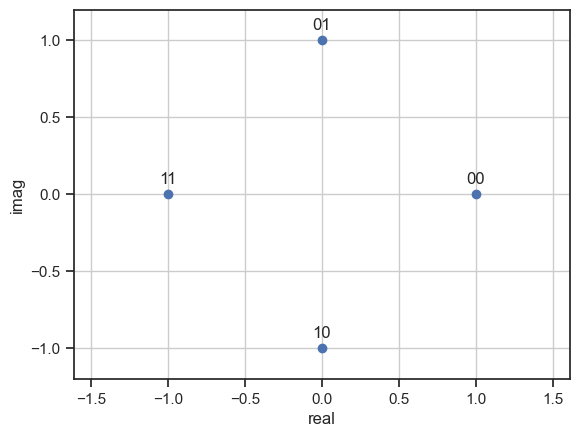

In [11]:
# plot the constellation
for k,v in QPSK.items():
    plt.plot(v.real, v.imag, 'bo', label=f"{k:02b}")
    plt.text(v.real, v.imag+0.05, f"{k:02b}", ha='center', va='bottom')
    
plt.grid()
plt.xlabel('real')
plt.ylabel('imag')
plt.axis('equal')
plt.xlim(-1.2, 1.2)
plt.ylim(-1.2, 1.2)
#plt.legend()

plt.show()

### Modulation Mapper Function

* a modulation mapper takes $\log_2(M)$ bits at a time and maps them to a symbol
  + first the bits are converted to a integer
  + this is very similar to `bits_to_byte`, except the number of bits could exceed 8.
* the lookup table is used to find the symbol that corresponds to the group of bits

In [12]:
def bits_to_int(bits):
    " convert a sequence of bits to an integer"
    res = 0 
    
    for b in bits:
        res = res << 1
        res = res + b
        
    return res

In [13]:
# Example:
bits = np.array([1, 0, 1, 1], dtype=np.uint8)
print( f"The bit sequence {bits} corresponds to decimal {bits_to_int(bits)}" )

The bit sequence [1 0 1 1] corresponds to decimal 11


We will also need the reverse function. This function must specify how many bits to produce.

In [14]:
def int_to_bits(nn, K):
    # allocate memory for bits
    bits = np.zeros(K, dtype=np.uint8)
    
    # define the mask
    mask = 1 << (K-1)
    
    for k in range(K):
        # extract the LSB and store it
        bits[k] = (nn & mask) >> (K-1)
        # shift the bits by one position
        nn = nn << 1
        
    return bits

In [15]:
K = 4
for n in range(2**K):
    assert bits_to_int( int_to_bits(n, K) ) == n
    
print('OK')

OK


Now, we're ready for the modulation mapper itself!

In [16]:
def mod_mapper(bits, mod_table):
    """map a sequence of bits to a sequence of symbols"""
    
    # how many bits per symbol?
    K = int( np.log2(len(mod_table)) )
    
    # how many symbols will we get?
    N = len(bits) // K
    syms = np.zeros(N, dtype=complex)
    
    for n in range(N):
        key = bits_to_int(bits[K*n : K*(n+1)])
        syms[n] = mod_table[key]
        
    return syms

In [17]:
## Example
string = "Hi"
bits = string_source( string )
mod_mapper( bits, QPSK )

array([ 0.+1.j,  1.+0.j, -0.-1.j,  1.+0.j,  0.+1.j, -0.-1.j, -0.-1.j,
        0.+1.j])

### Channel: discrete Gaussian noise channel

* Before implementing the demodulator, we provide a simple, but very relevant channel.
* Each transmitted symbol is corrupted by Gaussian noise
  + the Gaussian noise values are simulated using a random number generator
  + the noise has zero mean and
  + variance `sigma_sq`
* the function `dgnc` below, takes inputs
  + a sequence of symbols, and
  + a value for `sigma_sq`
* it returns a noisy sequence of symbols

In [18]:
def dgnc(symbols, sigma_sq):
    """discrete Gaussian noise channel"""
    n_syms = len(symbols)
    
    if syms.dtype == complex:
        noise = np.sqrt(sigma_sq/2) * (np.random.randn(n_syms) + 1j * np.random.randn(n_syms))
    else:
        noise = np.sqrt(sigma_sq) * np.random.randn(n_syms)
    
    return symbols + noise

### Received symbols

Let's see the impact that the noisy channel has on the transmitted symbols

* we pass transmitted symbols through the channel, and
* plot the received symbols in the complex plane
  + true symbol locations are shown for reference

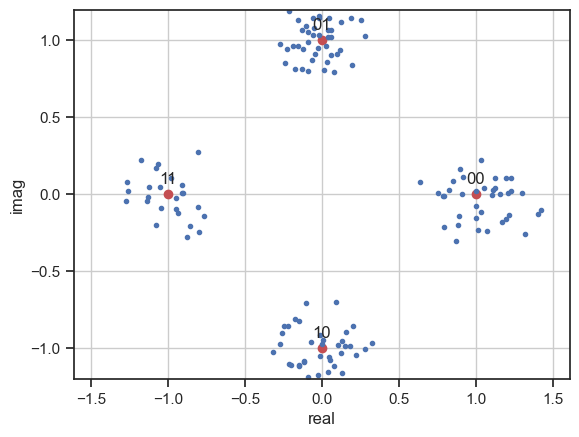

In [19]:
# Transmitter
string = "Now is the time for all good men ..."
bits = string_source( string )
syms = mod_mapper( bits, QPSK )

# Channel
sigma_sq = 0.05
rec_syms = dgnc(syms, sigma_sq)

# plot the constellation
for k,v in QPSK.items():
    plt.plot(v.real, v.imag, 'ro', label=f"{k:02b}")
    plt.text(v.real, v.imag+0.05, f"{k:02b}", ha='center', va='bottom')

# plot the received symbols
plt.plot(rec_syms.real, rec_syms.imag, '.')

plt.grid()
plt.xlabel('real')
plt.ylabel('imag')
plt.axis('equal')
plt.xlim(-1.2, 1.2)
plt.ylim(-1.2, 1.2)
#plt.legend()

plt.show()

* The noisy symbols are spread out around the transmitted signal locations.

* Our final task is to try and recover the original string from the noisy symbols.

* That is the task of the demodulator.

### Demodulator

* The demodulator finds the most likely transmitted symbol from the received symbols.
* for each received symbol:
  - find the symbol in the constellation that is **closest** to the received symbol
  - the key ('bit pattern') for that symbol is inserted into the received sequence of bits

In [20]:
def demodulator(syms, mod_table):
    """Recover bit sequence from reeived symbols"""
    # how many bits per symbol?
    K = int( np.log2(len(mod_table)) )
    
    # how many bits will we get?
    N = len(syms) * K
    bits = np.zeros(N, dtype=np.uint8)
    
    # find the constellation point closest to received symb `s`
    for n in range(len(syms)):
        s = syms[n]
        min_d = np.infty
        min_k = -1
        for k,v in mod_table.items():
            dist = np.abs(s - v)
            if dist < min_d:
                min_d = dist
                min_k = k
                
        # the index of the closest symbol is integer `min_k`
        # convert that to a sequence of K bits
        bits[n*K : (n+1)*K] = int_to_bits(min_k, K)
        
    return bits
            

In [21]:
## Let's see if we can get the transmitted string back ...
rec_bits = demodulator(rec_syms, QPSK)
string_sink(rec_bits)

'Now is the time for all good men ...'

## Putting it all together

The code below shows off all the processing steps we have discussed so far.  

We will build on this example as the semester progressess.

In [22]:
## Define another constellation: BPSK
BPSK = {0b0: 1,
        0b1: -1}

In [23]:
## Transmitter:
# Source
string = "ECE 460 is my favorite class"
bits = string_source(string)
# Modulation mapper
syms = mod_mapper(bits, BPSK)

## Channel
sigma_sq = 0.1
rec_syms = dgnc(syms, sigma_sq)

## Receiver
# Demodulator
rec_bits = demodulator(rec_syms, BPSK)
# Sink
string_sink(rec_bits)

'ECE 460 is my favorite class'